In [1]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
# Create path to home
home = str(Path.home())

# Create path to AoI shapefile
path_to_aoi = os.path.join(home, "Desktop", "drought-tracker", "data", "created", "aoi.shp")

# Load AoI into gpd
aoi = gpd.read_file(path_to_aoi)

In [3]:
# Create df with 1 county
path_to_county = os.path.join(home, "Desktop", "drought-tracker", "data", "TIGER", "cb_2018_us_county_500k.shp")

counties = gpd.read_file(path_to_county)

county = counties.loc[counties.NAME == 'Siskiyou']

county = county.to_crs('epsg:2019')

C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


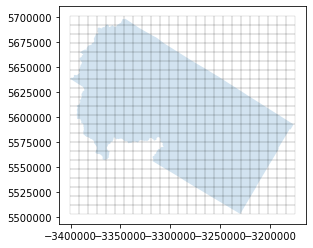

In [4]:
def create_awhere_grid(crs, aoi):
    """
    Parameters
    ----------
    crs: numeric string
        String of EPSG code for best CRS
        CRS must have units of meters
        
        
    aoi: Geopandas GeoDataFrame
        One-element GeoDataFrame containing area over which
        to draw grid
        
    Returns
    -------
    GeoDataFrame containing 9km x 9km cells
    """   
    
    # Reproject aoi to CRS using meters for aWhere grid cells
    aoi = aoi.to_crs(f'epsg:{crs}')
    
    # Get x and y min and max from total boundaries
    xmin, ymin, xmax, ymax = aoi.total_bounds
    
    # Set side of grid cell to 9 km
    side = 9000
    
    # Create x values for x points for rows
    x_range = np.arange(int(np.floor(xmin)), int(np.ceil(xmax)), side)
    
    # Create y values
    y_range = np.arange(int(np.floor(ymin)), int(np.floor(ymax)), side)
    
    # Create empty list to hold grid cells
    polygons = []
    
    for x in x_range:
        for y in y_range:
            polygons.append(Polygon([(x,y), (x+side, y), (x+side, y+side), (x,y+side)]))
            
    grid = gpd.GeoDataFrame({'geometry': polygons})
    
    grid.crs = f'EPSG:{crs}'
    
    return grid

grid = create_awhere_grid('2019', county)

# Create plot to check data
fig, ax = plt.subplots()

county.plot(alpha=0.2, ax=ax)

grid.plot(color="none", edgecolor="black", linewidth = 0.1, ax=ax)

plt.show()

In [7]:
# Create centroid
grid['centroid'] = grid.geometry.apply(lambda poly: poly.centroid)

In [8]:
# Pass each centroid to aWhere API
for index, row in grid.iterrows():
    centroid_x = row.centroid.x
    centroid_y = row.centroid.y